<a href="https://colab.research.google.com/github/kasprova/advanced_customer_analytics/blob/master/notebooks/feature_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## FEATURES GENERATION: (update 2019-10-20)


We have transaction data for 2 years. The first year (Sept 2015 - Aug 2016) data we use for our modeling, the second one we use for validation (Sept 2016 - Aug 2017).

### Features types 
We create a Universe table with the following type of features (monthly aggregation for the period: **Sept 2015 - Aug 2016**):

- RFM features 
- Churn feature
- Discount applied/bottle diposites/refund(Number, Total value of Discount)
- Categories of Products Purchased - proportion of money spent on a particuler category of products
- Loyalty program features (Duration sience start, Number of loyalty cards)

In [1]:
!nvidia-smi

Fri Oct 25 20:03:52 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.50       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://www-us.apache.org/dist/spark/spark-2.4.4/spark-2.4.4-bin-hadoop2.7.tgz
!tar xf spark-2.4.4-bin-hadoop2.7.tgz
!pip install -q findspark

In [0]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.4-bin-hadoop2.7"

In [0]:
import findspark
findspark.init()

import pyspark
from pyspark import SparkConf
conf = SparkConf().setAppName("App")
conf = (conf.set('spark.driver.memory', '11G'))

sc = pyspark.SparkContext(conf=conf)
from pyspark.sql import SQLContext
sql = SQLContext(sc)

from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [0]:
from functools import reduce
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline 
#plt.style.use('ggplot')
plt.style.use('default')
plt.rcParams["figure.figsize"] = (5,5)


In [0]:
from pyspark.sql.functions import dayofmonth, to_date, datediff, length, first

### Mount dataset from Google Disk to Google Colab

In [8]:
#mount google drive to get access to the data
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!unzip -q "drive/My Drive/analytics/DATA.zip"

In [0]:
#load data
stores = spark.read.parquet("stores.parquet")
#unique_customers = spark.read.parquet("unique_customers.parquet")
transactions = spark.read.parquet("transactions.parquet")
categories = spark.read.parquet("categories.parquet")
cat_manual = spark.read.parquet("cat_manual.parquet")
dim_cal_date = spark.read.parquet("dim_cal_date_SB.parquet")
customers = spark.read.parquet("clients.parquet")
upc_base = spark.read.parquet("upc_base.parquet")

#create views for sql queries
stores.createOrReplaceTempView('stores')
#unique_customers.createOrReplaceTempView('unique_customers')
transactions.createOrReplaceTempView('transactions')
categories.createOrReplaceTempView('categories')
cat_manual.createOrReplaceTempView('cat_manual')
dim_cal_date.createOrReplaceTempView('dim_cal_date')
customers.createOrReplaceTempView('customers')
upc_base.createOrReplaceTempView('upc_base')


#### 1. RFM features

 - month_id - id of month when a customer made a purchase
 - household_id - id number of household (link to the address, each household can have a few cards)
 - recency - how many days ago from the first day of the next month the last purchase was done
 - frequency - how many times per particular month a customer made purchases
 - monetary - how much money a customer spent for purchases in particular month (converted into dollars, incluse in calculations only when a total amount more than 1 dollar)
 



In [0]:
# define Recency (time of last purchase), Frequency, MonetaryValue
fm_features = spark.sql("""
select 
    month_id,
    household_id, -- link to the address - each household can have a few cards
    max(cal_date) as last_purchase,
    count(distinct trans_id) as frequency,
    round(sum(net_sales_amount/100),2) as monetary --convert from cents to dollars
from transactions t
    join dim_cal_date cd
    on date_format(cd.cal_date,'yyyyMMdd') = substring(t.local_trans_datetime,0,8)
    join customers uc
    on uc.card_number = t.card_number
    where item_type in (0,20) -- 0 - item purchased, 20 - discard the item, all the rest some coupons/discounts/bottles..
    and month_id between 201509 and 201608
group by 1,2
""")
fm_features.createOrReplaceTempView('fm_features')

In [0]:
# adding Recency: who pays more than 1 dollar 
rfm_features = spark.sql("""
select  c.month_id,
        household_id, 
        datediff(concat(substring(next_month_id,0,4), '-',substring(next_month_id,5,2),'-01'), last_purchase) as recency, -- max_day +1
        frequency,
        monetary
from fm_features c
join dim_cal_date cd 
    on c.month_id = cd.month_id
where Monetary >=1
group by 1,2,3,4,5
order by 1,2
""")
rfm_features.createOrReplaceTempView('rfm_features')

In [0]:
 #spark.sql("""
#  select min(local_trans_datetime),
#          max(local_trans_datetime)
#  from transactions
#  """).show()
#+-------------------------+-------------------------+
#|min(local_trans_datetime)|max(local_trans_datetime)|
#+-------------------------+-------------------------+
#|        20150816 00:01:03|        20171029 23:59:21|
#+-------------------------+-------------------------+

#### 2. Churn Feature
  - churn - we consider all history of purchases of a particular customer. If the last purchase was done in the considered month of purchase and it is not the last historically available month than this customer 'churned'

In [0]:
churn_feature = spark.sql("""
select 
    rfm.month_id,
    rfm.household_id, 
    case when rfm.month_id = LastMonthPurchase and rfm.month_id not in (201710) then 1
        else 0 end as churn
from rfm_features rfm
join (select 
        household_id, 
        max(month_id) LastMonthPurchase
      from transactions t
      join dim_cal_date cd
        on date_format(cd.cal_date,'yyyyMMdd') = substring(t.local_trans_datetime,0,8)
      join customers uc
        on uc.card_number = t.card_number
      where item_type in (0,20)
      group by 1) x
  on rfm.household_id = x.household_id 
""")
churn_feature.createOrReplaceTempView('churn_feature')

#### 3. Discount applied (Number, Total value of Discount)

    3.1 Discounts
    3.2 Bottles
    3.3 Refunds

In [0]:
# 3.1 discounts
discount_features = spark.sql("""
    select month_id,
           household_id,
           sum(case 
                   when item_type in (1,21) then discount_number 
                   else 0
               end) as discount_number__store_coupon,
           sum(case 
                   when item_type in (1,21) then discount_value
                   else 0
               end) as discount_value__store_coupon,
           
           sum(case 
                   when item_type in (2,22) then discount_number 
                   else 0
               end) as discount_number__manufacture_coupon,
           sum(case 
                   when item_type in (2,22) then discount_value 
                   else 0
               end) as discount_value__manufacture_coupon,
           
           sum(case 
                   when item_type in (3,23) then discount_number 
                   else 0
               end) as discount_number__misc_credit,
           sum(case 
                   when item_type in (3,23) then discount_value 
                   else 0
               end) as discount_value__misc_credit,
           
           sum(case 
                   when item_type in (5,25) then discount_number 
                   else 0
               end) as discount_number__xxx_credit,
           sum(case 
                   when item_type in (5,25) then discount_value 
                   else 0 
               end) as discount_value__xxx_credit,
           
           sum(discount_number) as discount_number__total,
           sum(discount_value) as discount_value__total      
    from (
        select  cd.month_id,
                uc.household_id, 
                item_type,
                count(distinct upc) as discount_number,
                round(sum(sales_amount/100),2) as discount_value
        from transactions t
            join dim_cal_date cd
            on date_format(cd.cal_date,'yyyyMMdd') = substring(t.local_trans_datetime,0,8)
            join customers uc
            on uc.card_number = t.card_number
            where item_type in (1,2,3,5,21,22,23,25) 
            and month_id between 201509 and 201608
        group by 1,2,3)x
    group by 1,2
    order by 1,2
""")
discount_features.createOrReplaceTempView('discount_features')

In [0]:
# 3.2 bottles
bottle_features = spark.sql("""
    select month_id,
           household_id,
           sum(case 
                   when item_type in (9,29) then discount_number 
                   else 0
               end) as deposite_number__bottle,
           sum(case 
                   when item_type in (9,29) then discount_value
                   else 0
               end) as deposite_value__bottle,
           
           sum(case 
                   when item_type in (10,30) then discount_number 
                   else 0
               end) as return_number__bottle,
           sum(case 
                   when item_type in (10,30) then discount_value 
                   else 0
               end) as return_value__bottle    
    from (
        select  cd.month_id,
                uc.household_id, 
                item_type,
                count(distinct upc) as discount_number,
                round(sum(sales_amount/100),2) as discount_value
        from transactions t
            join dim_cal_date cd
            on date_format(cd.cal_date,'yyyyMMdd') = substring(t.local_trans_datetime,0,8)
            join customers uc
            on uc.card_number = t.card_number
            where item_type in (9,29,10,30)
            and month_id between 201509 and 201608
        group by 1,2,3)x
    group by 1,2
    order by 1,2
""")
bottle_features.createOrReplaceTempView('bottle_features')

In [0]:
# 3.3 refund
refund_features = spark.sql("""
    select month_id,
           household_id,
           sum(case 
                   when item_type in (7) then discount_number 
                   else 0
               end) as refund_number,
           sum(case 
                   when item_type in (7) then discount_value
                   else 0
               end) as refund_value  
    from (
        select  cd.month_id,
                uc.household_id, 
                item_type,
                count(distinct upc) as discount_number,
                round(sum(sales_amount/100),2) as discount_value
        from transactions t
            join dim_cal_date cd
            on date_format(cd.cal_date,'yyyyMMdd') = substring(t.local_trans_datetime,0,8)
            join customers uc
            on uc.card_number = t.card_number
            where item_type in (7)
            and month_id between 201509 and 201608
        group by 1,2,3)x
    group by 1,2
    order by 1,2
""")
refund_features.createOrReplaceTempView('refund_features')

#### 4. Money proportion spend per each category of products (manual categories: 60 categories manually combined into 12)

In [0]:
trans_base = spark.sql("""
    select trans_id,
           round(sum(t.net_sales_amount)/100,2) sum_paid_amout
     from transactions t
     join dim_cal_date cd
        on date_format(cd.cal_date,'yyyyMMdd') = substring(t.local_trans_datetime,0,8)
     where month_id between 201509 and 201608
     group by 1  
     having round(sum(t.net_sales_amount)/100,2)>0
""")
trans_base.createOrReplaceTempView("trans_base")

#to speedup the process
selected_transactions = spark.sql("""
    select t.*
    from transactions t
    join trans_base tb
      on t.trans_id = tb.trans_id
    join dim_cal_date cd
      on date_format(cd.cal_date,'yyyyMMdd') = substring(t.local_trans_datetime,0,8)
    where month_id between 201509 and 201608
""")
selected_transactions.createOrReplaceTempView("selected_transactions")


sum_by_cat_m = spark.sql("""
    select cd.month_id,
           u.household_id,
           cm.category_manual,
           sum(t.net_sales_amount) sum_paid_amout
     from selected_transactions t, customers u, categories c, dim_cal_date cd, cat_manual cm
     where t.item_type in (0,20)
       and u.card_number = t.card_number
       and lpad(c.upc,14,'0') = lpad(t.upc,14,'0')
       and date_format(cd.cal_date,'yyyyMMdd') = substring(t.local_trans_datetime,0,8)
       and c.category_id2 is not null
       and cm.category = lower(regexp_replace(c.category_desc2," ","_"))
       -- and month_id between 201509 and 201608
     group by cd.month_id, u.household_id, cm.category_manual  
     having sum(t.net_sales_amount)>0
""")
sum_by_cat_m.createOrReplaceTempView("sum_by_cat_m")


total_sum = spark.sql("""
    select month_id,
           household_id,
           sum(sum_paid_amout) total_paid_amout
     from sum_by_cat_m
     group by 1,2
""")
total_sum.createOrReplaceTempView("total_sum")


cat_portion_m = spark.sql("""
    select d.month_id,
           d.household_id,
           d.category_manual,
           d.sum_paid_amout/ t.total_paid_amout cat_portion
      from sum_by_cat_m d, total_sum t
     where d.household_id = t.household_id
         and d.month_id = t.month_id
""")
cat_portion_m.createOrReplaceTempView("cat_portion_m")


cat_m_portion_features = cat_portion_m.groupBy('month_id','household_id').pivot('category_manual').sum('cat_portion')
cat_m_portion_features = cat_m_portion_features.fillna(0)

for c in cat_m_portion_features.columns[2:]:
    cat_m_portion_features = cat_m_portion_features.withColumnRenamed(c, 'cat_m_{}_paid_amount_pcnt'.format(c))
    
    
cat_m_portion_features.createOrReplaceTempView('cat_m_portion_features')

#### 5. Loyalty program features (Duration sience start,  Number of loyalty cards)
Comments: 

    - duration since start counted in months (difference between registration date and last purchase in a selected month)

In [0]:
#number of cards
cards_info = spark.sql("""
    select household_id,
           count(distinct card_number) as cards_number,
           min(first_shop_date) as first_shop_date
    from customers
    where first_shop_date <> '1900-01-01 00:00:00'
    group by 1
""")
cards_info.createOrReplaceTempView('cards_info')



#all together
loyalty_features = spark.sql("""
    select month_id,
           fm.household_id,
           cards_number,
           case when (cast((substring(last_purchase,0,4)-substring(first_shop_date,0,4))*12 +
                      (substring(last_purchase,6,2) - substring(first_shop_date,6,2)) as int))<0 
                          then 0
                else (cast((substring(last_purchase,0,4)-substring(first_shop_date,0,4))*12 +
                      (substring(last_purchase,6,2) - substring(first_shop_date,6,2)) as int)) 
                end as duration_since_start__months
    from fm_features fm
    join cards_info ci
    on fm.household_id = ci.household_id
""")
loyalty_features.createOrReplaceTempView('loyalty_features')

#### 6. Create universal feature table

In [0]:
#join features together
features = spark.sql("""
    select  distinct 
            a.month_id,
            a.household_id,
            
            a.recency,
            a.frequency,
            a.monetary,
            
            g.churn,
            
            b.discount_number__store_coupon,
            b.discount_value__store_coupon,
            b.discount_number__manufacture_coupon,
            b.discount_value__manufacture_coupon,
            b.discount_number__misc_credit,
            b.discount_value__misc_credit,
            b.discount_number__xxx_credit,
            b.discount_value__xxx_credit,
            b.discount_number__total,
            b.discount_value__total,
            
            e.deposite_number__bottle,
            e.deposite_value__bottle,
            e.return_number__bottle,
            e.return_value__bottle,
            
            f.refund_number,
            f.refund_value,
            
            c.cat_m_alco_tabacco_paid_amount_pcnt,
            c.cat_m_baby_and_pets_paid_amount_pcnt,
            c.cat_m_baking_paid_amount_pcnt,
            c.cat_m_diary_paid_amount_pcnt,
            c.cat_m_drinks_paid_amount_pcnt,
            c.cat_m_grains_paid_amount_pcnt,
            c.cat_m_greens_paid_amount_pcnt,
            c.cat_m_misc_paid_amount_pcnt,
            c.cat_m_prepared_food_paid_amount_pcnt,
            c.cat_m_proteins_paid_amount_pcnt,
            c.cat_m_sause_paid_amount_pcnt,
            c.cat_m_sweets_paid_amount_pcnt,
            
            d.duration_since_start__months,
            d.cards_number  
            
    from rfm_features a
    left join discount_features b
        on a.month_id = b.month_id
        and a.household_id = b.household_id
    left join cat_m_portion_features c
        on a.month_id = c.month_id
        and a.household_id = c.household_id
    left join loyalty_features d
        on a.month_id = d.month_id
        and a.household_id = d.household_id  
    left join bottle_features e
        on a.month_id = e.month_id
        and a.household_id = e.household_id
    left join refund_features f
        on a.month_id = f.month_id
        and a.household_id = f.household_id
    left join churn_feature g
        on a.month_id = g.month_id
        and a.household_id = g.household_id
""")

features = features.fillna(0)
features.createOrReplaceTempView('features')

In [0]:
#save to a file: parquet
features.write.mode("overwrite").parquet("universal_features_manual_cat_201509_201608__.parquet")

In [135]:
#zip parquet folder
!zip -r universal_features_manual_cat_201509_201608__.zip universal_features_manual_cat_201509_201608__.parquet

  adding: universal_features_manual_cat_201509_201608__.parquet/ (stored 0%)
  adding: universal_features_manual_cat_201509_201608__.parquet/.part-00063-f12755bc-cfa5-422a-8134-1441dc861c0e-c000.snappy.parquet.crc (stored 0%)
  adding: universal_features_manual_cat_201509_201608__.parquet/.part-00081-f12755bc-cfa5-422a-8134-1441dc861c0e-c000.snappy.parquet.crc (stored 0%)
  adding: universal_features_manual_cat_201509_201608__.parquet/part-00062-f12755bc-cfa5-422a-8134-1441dc861c0e-c000.snappy.parquet (deflated 12%)
  adding: universal_features_manual_cat_201509_201608__.parquet/part-00086-f12755bc-cfa5-422a-8134-1441dc861c0e-c000.snappy.parquet (deflated 11%)
  adding: universal_features_manual_cat_201509_201608__.parquet/.part-00148-f12755bc-cfa5-422a-8134-1441dc861c0e-c000.snappy.parquet.crc (stored 0%)
  adding: universal_features_manual_cat_201509_201608__.parquet/part-00134-f12755bc-cfa5-422a-8134-1441dc861c0e-c000.snappy.parquet (deflated 11%)
  adding: universal_features_manual

----------

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb0ebe9da20>,
      dtype=object)

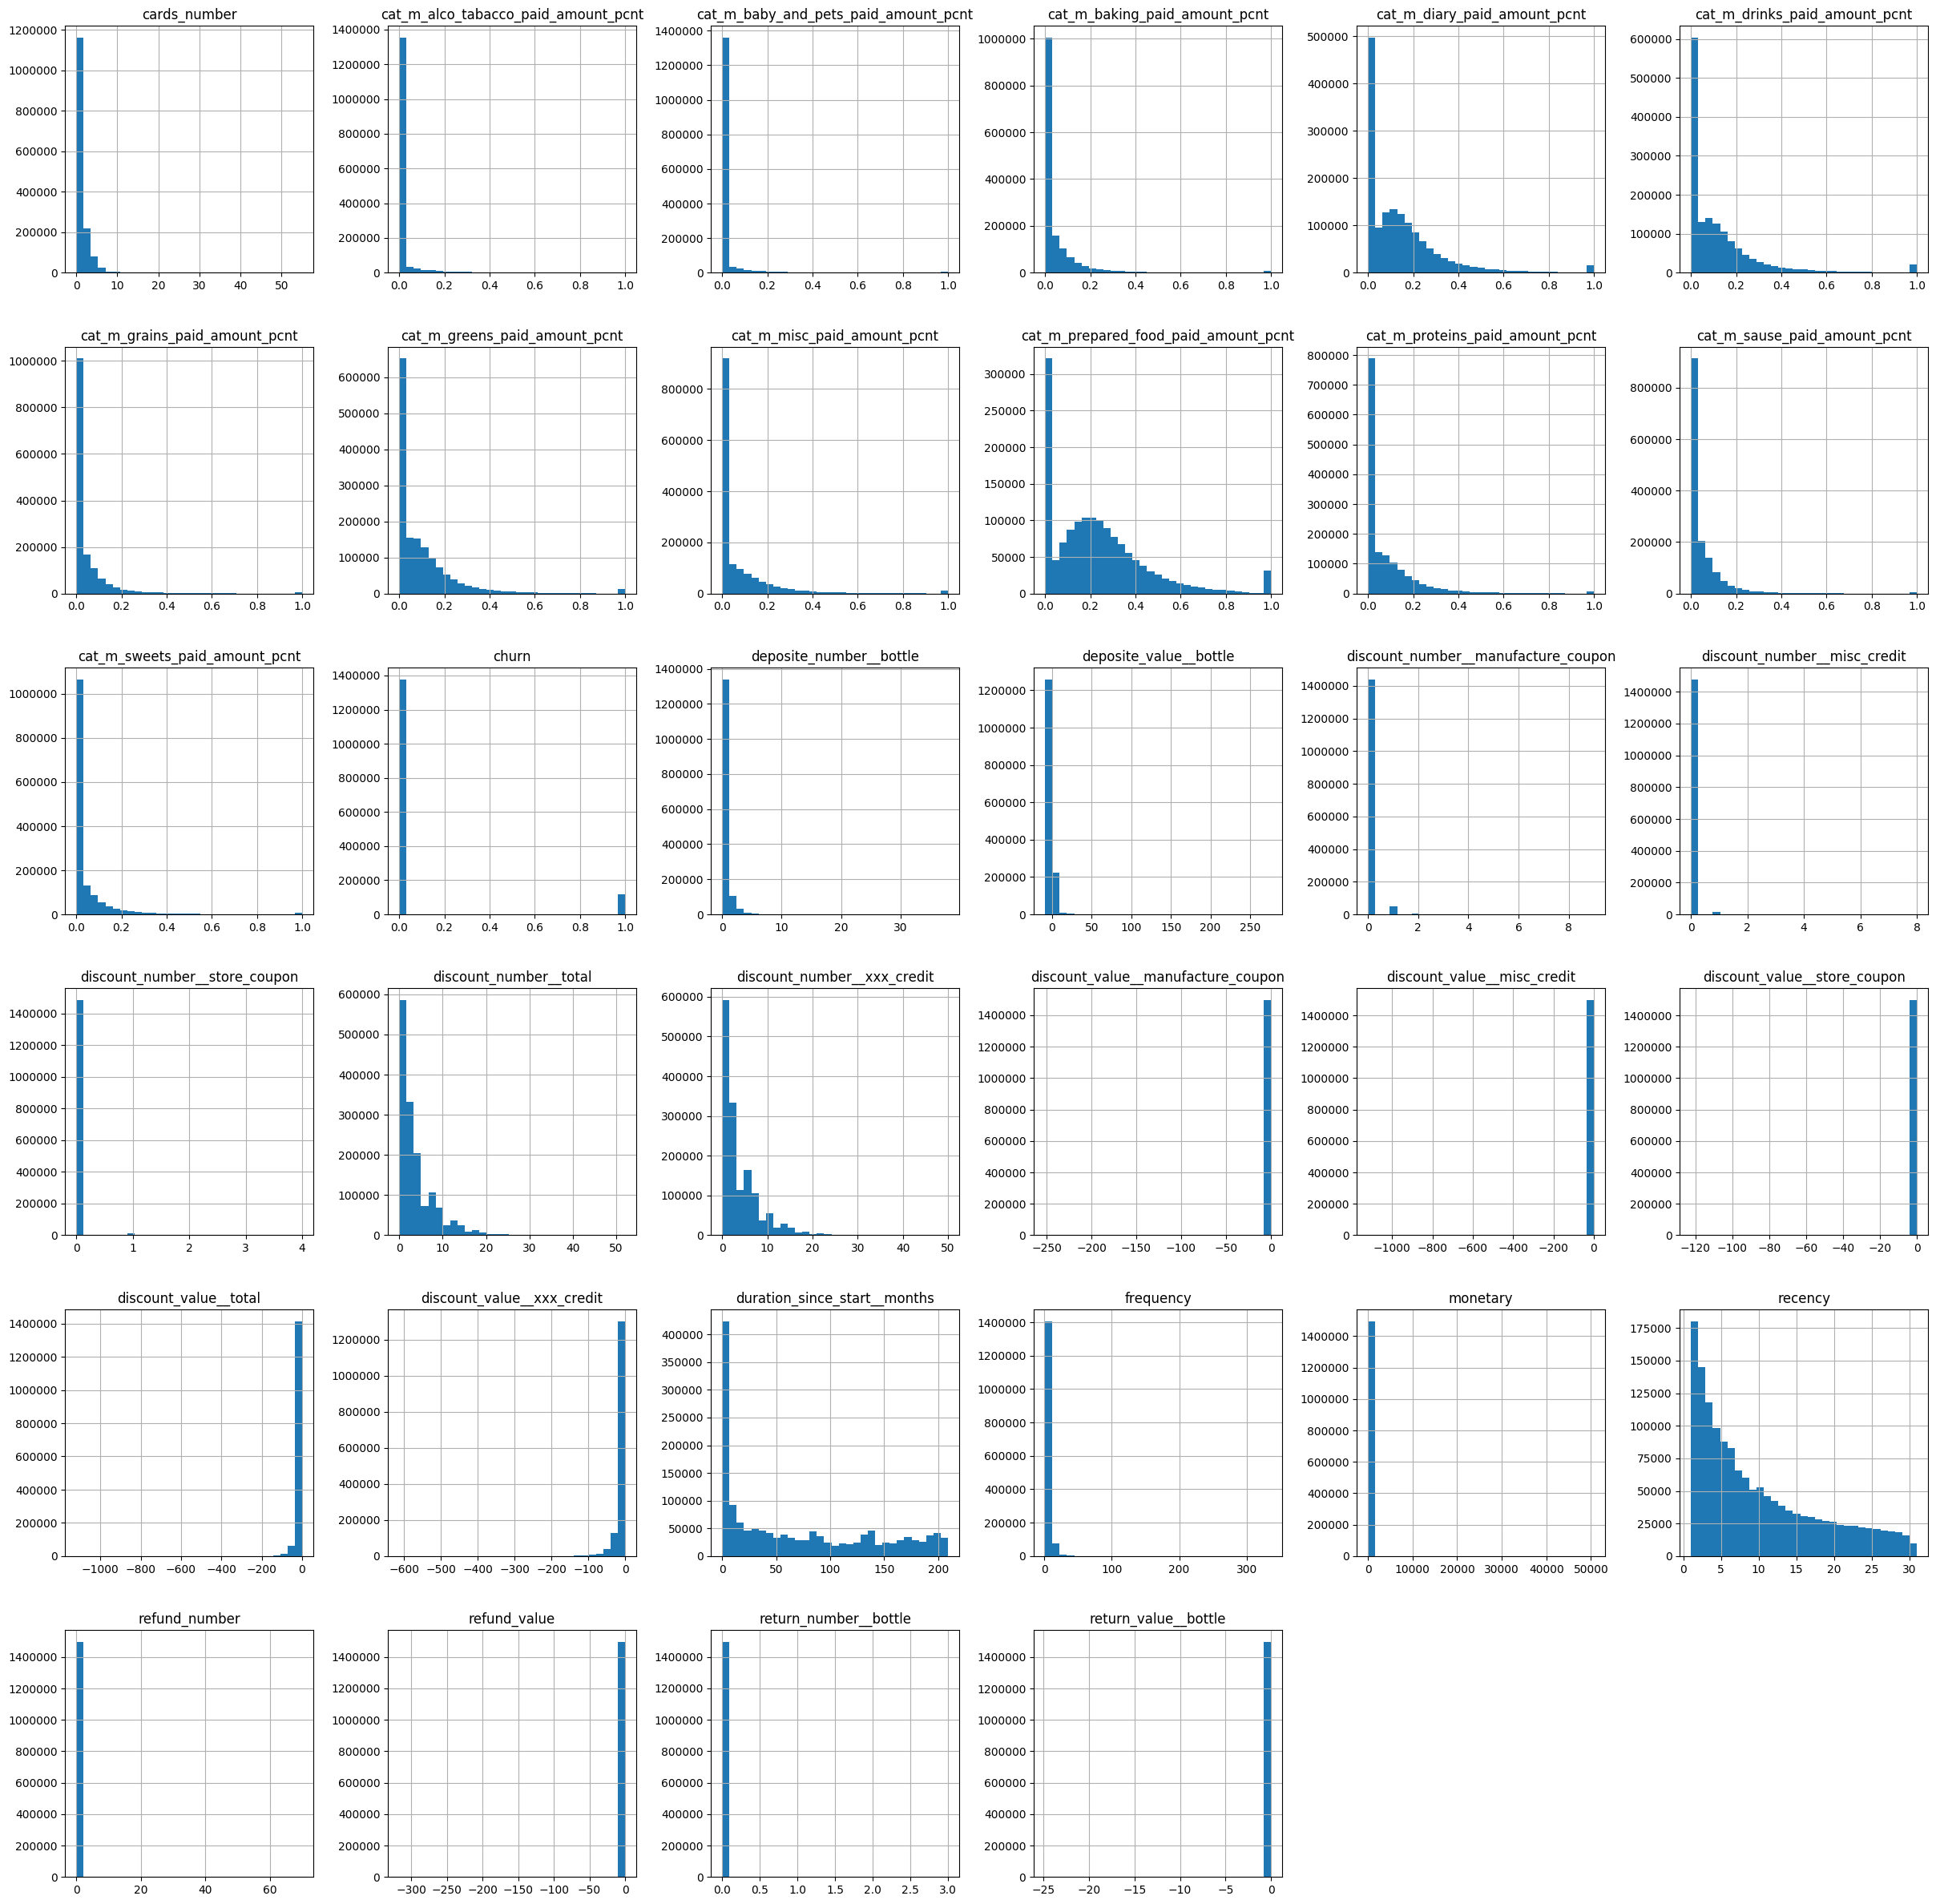

In [136]:
df_features = pd.read_parquet("universal_features_manual_cat_201509_201608__.parquet")
plt.rcParams["figure.figsize"] = (30,30)
df_features.iloc[:,2:].hist(bins=31) 

In [137]:
for i in range(df_features.shape[1])[2:]:
  print(df_features.iloc[:,i].name)
  print(np.sort(df_features.iloc[:,i].unique()))

recency
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31]
frequency
[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  82  83  84  85  87  88  89  90  92  93
  94  95  97  99 101 103 108 109 110 111 112 115 117 122 123 124 125 126
 128 133 137 138 140 150 177 336]
monetary
[1.000000e+00 1.010000e+00 1.020000e+00 ... 4.971808e+04 5.003415e+04
 5.065036e+04]
churn
[0 1]
discount_number__store_coupon
[0 1 2 3 4]
discount_value__store_coupon
[-1.2252e+02 -9.4800e+01 -8.6600e+01 -8.5900e+01 -7.6190e+01 -6.6800e+01
 -6.3450e+01 -6.0430e+01 -6.0090e+01 -5.7740e+01 -5.7000e+01 -5.1050e+01
 -4.6820e+01 -4.6200e+01 -4.5500e+01 -4.5000e+01 -4.1470e+01 -3.8750e+01
 -3.6300e+01 -3.59

In [138]:
#how many ppl churned
df_features[(df_features["churn"]==1)].groupby(["month_id"])["churn"].count()

month_id
201509       10
201510       14
201511     8789
201512     9766
201601    10764
201602    10999
201603    13381
201604    12467
201605    13262
201606    13292
201607    14286
201608    12823
Name: churn, dtype: int64